# Figure 2: iModulon Overview

## Setup

In [1]:
from os import path
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.io import load_json_model
from pymodulon.plotting import *

### Set plotting style

In [2]:
sns.set_style('ticks')
plt.style.use('custom.mplstyle')

### Load data

In [3]:
figure_dir = 'raw_figures'
data_dir = path.join('..','data','processed_data')

In [4]:
data_file = path.join(data_dir,'bsu.json.gz')
ica_data = load_json_model(data_file)

## Panel A: Explained Variance

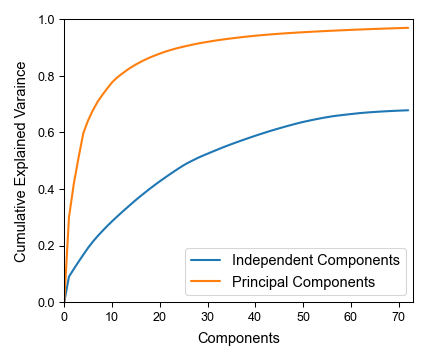

In [5]:
plot_explained_variance(ica_data)
plt.savefig(path.join(figure_dir,'Fig2a_explained_variance.pdf'))

# Panel B: Threshold

In [36]:
zur_genes = ica_data.trn[ica_data.trn.regulator=='Zur'].gene_id.values

groups = dict([(gene,'Regulated\nby Zur') if gene in zur_genes else
               (gene,'No known\nregulation') for gene in ica_data.gene_names])

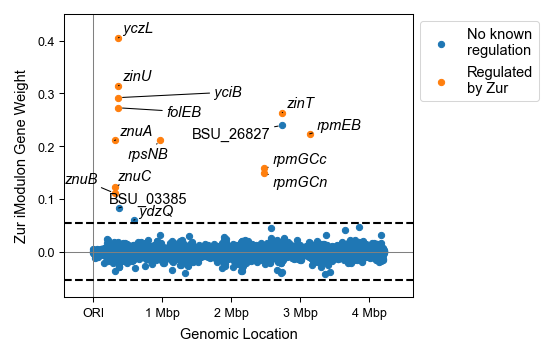

In [42]:
ax = plot_gene_weights(ica_data, 'Zur', label_font_kwargs={'fontsize':7}, groups=groups)
ax.set_ylabel('Zur iModulon Gene Weight')
ax.set_xlabel('Genomic Location')
ax.set_xticklabels(['','ORI','1 Mbp','2 Mbp','3 Mbp','4 Mbp']);
plt.savefig(path.join('raw_figures','Fig2b_gene_thresholds.pdf'))

## Panel C: Tree map 
See R notebook

In [7]:
data_for_treemap = ica_data.imodulon_table[['function','explained_variance']].reset_index()
data_for_treemap.columns = ['iModulon','function','size']
data_for_treemap.replace({'Single Gene':'ZSingle Gene','Uncharacterized':'ZUncharacterized'}, inplace=True)
data_for_treemap.head()

,iModulon,function,size
0,S-box,AA/Nucleotide Metabolism,0.010646
1,uncharacterized-1,ZUncharacterized,0.006978
2,WalR,Cellular Processes,0.003324
3,uncharacterized-2,ZUncharacterized,0.001433
4,Rex,Misc. Metabolism,0.004055


In [8]:
data_for_treemap.to_csv(path.join('..','data','interim','data_for_treemap.csv'))

## Panel D: Precision-recall scatter

In [44]:
reg_table = ica_data.imodulon_table[ica_data.imodulon_table.category=='regulatory']

In [45]:
palette = sns.color_palette('Set2')

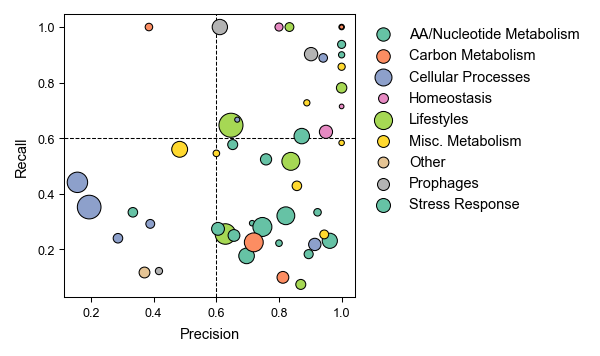

In [49]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
for i,cat in enumerate(sorted(reg_table.function.unique())):
    data = reg_table[reg_table.function == cat]
    ax.scatter(data.precision, 
               data.recall,
               s = data.imodulon_size,
               c = [palette[i%len(palette)]],
               edgecolor='k',label=cat,
              zorder=10-i)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

# Legend
ax.legend(bbox_to_anchor=(1,1), frameon=False)

# Lines
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.hlines(0.6, xmin, xmax, linestyle='dashed',linewidth=0.5,zorder=0)
ax.vlines(0.6, ymin, ymax, linestyle='dashed',linewidth=0.5,zorder=0)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.savefig(path.join('raw_figures','Fig2d_precision_recall.pdf'))

# Panel E: SigB iModulons

In [12]:
from itertools import combinations

In [13]:
sigB1 = set(ica_data.view_imodulon('SigB-1').index)
sigB2 = set(ica_data.view_imodulon('SigB-2').index)
sigB3 = set(ica_data.view_imodulon('SigB-3').index)
sigB_reg = set(ica_data.trn[ica_data.trn.regulator == 'SigB'].gene_id)

sigB_sets = [sigB1, sigB_reg, sigB2, sigB3]

In [14]:
overlaps = [len(set.intersection(*sets)) for n in [1,2,3,4] for sets in combinations(sigB_sets,n)]

In [15]:
overlaps

[53, 221, 56, 83, 51, 16, 20, 39, 62, 11, 16, 19, 2, 11, 2]

# Panel F: ResD Motif

In [16]:
from pymodulon.motif import find_motifs,compare_motifs

In [17]:
find_motifs(ica_data,'ResD',path.join('..','data','external','genome.fasta'),
            maxw=25,force=True)

Finding motifs for 35 sequences
Running command: meme motifs/ResD.fasta -oc motifs/ResD -dna -mod zoops -p 8 -nmotifs 5 -evt 0.001 -minw 6 -maxw 25 -allw -minsites 11
Found 2 motifs across 49 sites


<MotifInfo with 2 motifs across 49 sites>

In [18]:
ica_data.motif_info['ResD'].motifs

,e_value,sites,width,consensus,motif_frac
motif,,,,,
MEME-1,3.1e-12,35,16,WWRVMAAAAAMAGCRG,1.0
MEME-2,3.8e-11,14,22,WHTTTCAYAAAATSTWCAAAAA,0.4


In [19]:
ica_data.motif_info['ResD'].file

'motifs/ResD/meme.txt'

In [23]:
shutil.copyfile(path.join('motifs','ResD','logo1.eps'),path.join('raw_figures','Fig2f_motif.eps'))

'raw_figures/Fig2f_motif.eps'

## Check for similarity to known motifs

In [19]:
res = compare_motifs(ica_data.motif_info['ResD'],
                     force=False,evt=0.1)

In [20]:
res

,motif,target,target_id,pvalue,Evalue,qvalue,overlap,optimal_offset,orientation,database


# Numbers for manuscript

In [21]:
print('Number of iModulons:',len(ica_data.imodulon_names))
print('Percent variance explained: {:.0f}%'.format(explained_variance(ica_data)*100))

Number of iModulons: 72
Percent variance explained: 67%


In [22]:
table = ica_data.imodulon_table[ica_data.imodulon_table.category=='regulatory']
print('Number of Regulatory iModulons:',len(table))
print('Percent variance explained: {:.0f}%'.format(table.explained_variance.sum()*100))

Number of Regulatory iModulons: 52
Percent variance explained: 57%


In [23]:
table = ica_data.imodulon_table[ica_data.imodulon_table.category=='single_gene']
print('Number of Regulatory iModulons:',len(table))
print('Percent variance explained: {:.0f}%'.format(table.explained_variance.sum()*100))

Number of Regulatory iModulons: 5
Percent variance explained: 1%


In [24]:
table = ica_data.imodulon_table[ica_data.imodulon_table.category=='functional']
print('Number of Regulatory iModulons:',len(table))
print('Percent variance explained: {:.0f}%'.format(table.explained_variance.sum()*100))

Number of Regulatory iModulons: 9
Percent variance explained: 8%


In [25]:
table = ica_data.imodulon_table[ica_data.imodulon_table.category=='uncharacterized']
print('Number of Regulatory iModulons:',len(table))
print('Percent variance explained: {:.0f}%'.format(table.explained_variance.sum()*100))

Number of Regulatory iModulons: 6
Percent variance explained: 2%
